In [1]:
%pip install missingno MissForest lazypredict

Note: you may need to restart the kernel to use updated packages.


In [49]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import missingno as msno
import matplotlib.pyplot as plt

# NOTA
El DataFrame df se crea a partir de la tabla basa_datos_pripal de la base de datos credit_scoring.db. El archivo no se incluye en el repositorio debido a su tamaño; la generación de la base de datos a partir del CSV original y la creación de la tabla se explica detalladamente en el notebook data-collection.ipynb

Descriptive analysis:
In this part of the project, we begin exploring the dataset created from the initial information obtained from the LendingClub dataset (Kaggle). The objective of this stage is to describe and understand the structure of the data, the variables and their types, their distributions, skewness, and the presence of missing values.

In [51]:
conn = sqlite3.connect(r"C:\Users\User\Documents\GITHUB\final_project_creditscoring\Data\credit_scoring.db")
df = pd.read_sql("SELECT * FROM main_table", conn)
conn.close()
n_rows,n_cols = df.shape

print(f'En este df existen {n_rows} filas y {n_cols} columnas')

En este df existen 192309 filas y 157 columnas


With the analysis below, we can understand that the dataset contains a large number of numerical variables, along with several categorical features represented as object types. This initial inspection highlights the need for feature selection and type handling in later stages. 

In [52]:
object_cols = df.select_dtypes(include="object").columns.tolist()
int_cols = df.select_dtypes(include="int64").columns.tolist()
float_cols = df.select_dtypes(include="float64").columns.tolist()

print(f"Objects: {len(object_cols)}")
print(f"Ints: {len(int_cols)}")
print(f"Floats: {len(float_cols)}")

Objects: 38
Ints: 1
Floats: 118


The code below is intended to help us understand whether we have incorrectly typed columns that should be numeric instead of objects. The fact that, when we execute the code, the list is empty tells us that our data is mostly properly typed and that we don’t have object columns that should be numbers.

In [53]:
numeric_like = []

for col in object_cols:
    converted = pd.to_numeric(df[col], errors="coerce")
    ratio = converted.notna().mean()

    if ratio > 0.9:  # 90% convertible
        numeric_like.append(col)

numeric_like

[]

In [54]:
for col in object_cols:
    print(f"\n{col}")
    print(df[col].value_counts().head(5))


member_id
Series([], Name: count, dtype: int64)

term
term
36 months    137427
60 months     54882
Name: count, dtype: int64

grade
grade
B    57960
C    51411
A    37376
D    27537
E    12464
Name: count, dtype: int64

sub_grade
sub_grade
B3    12891
B4    12350
C1    12011
B5    11754
C2    11060
Name: count, dtype: int64

emp_title
emp_title
Teacher             2291
Manager             2088
Owner               1205
Registered Nurse     956
RN                   921
Name: count, dtype: int64

emp_length
emp_length
10+ years    60362
2 years      17441
< 1 year     16162
3 years      15651
5 years      13229
Name: count, dtype: int64

home_ownership
home_ownership
MORTGAGE    94097
RENT        78851
OWN         19276
ANY            49
NONE           19
Name: count, dtype: int64

verification_status
verification_status
Source Verified    67899
Not Verified       62663
Verified           61747
Name: count, dtype: int64

issue_d
issue_d
2011-10-01 00:00:00    1941
2011-11-01 00:00:00    

Column format review – findings:
1. No numeric-like object columns detected. All object variables represent categorical or textual information.
2. Multiple date-related columns are stored as object and will require conversion to datetime.
3. Several high-cardinality or free-text columns (emp_title, url, desc) were identified as non-informative for modeling and will be considered for removal in later steps.

Revision of constant columns: 

The following code initially didn’t specify dropna=False, which made it show a few columns as constants. This led us to investigate what was happening and whether we were working with the right dataframe. However, this mistake was enlightening, as it helped us identify possible *data leakage variables, such as: hardship_type, deferral_term, and hardship_length.*

In [55]:
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# Unique values per column
uniq = df.nunique(dropna=False)

# Show results
print(uniq)


id                                            192309
member_id                                          1
loan_amnt                                       1456
funded_amnt                                     1457
funded_amnt_inv                                 4943
term                                               2
int_rate                                         500
installment                                    42329
grade                                              7
sub_grade                                         35
emp_title                                      92693
emp_length                                        12
home_ownership                                     6
annual_inc                                     15650
verification_status                                3
issue_d                                          103
loan_status                                        9
pymnt_plan                                         2
url                                           

In [56]:
uniq = df.nunique(dropna=False)
uniq[uniq == 1]

member_id      1
policy_code    1
dtype: int64

After the code revision, the only two variables with constant values are member_id and policy_code. It does not make much sense to have a unique value for member_id if we have almost 200k data entries, so we needed to check the exact values contained in this column.

In [57]:
cols = ['member_id', 'policy_code']

for col in cols:
    print(df[col].value_counts(dropna=False))

member_id
None    192309
Name: count, dtype: int64
policy_code
1.0    192309
Name: count, dtype: int64


Below, we proceed to drop from the dataset the columns that aren’t relevant to the analysis or that were identified as redundant.

In [58]:
df = df.drop(columns=['member_id', 'policy_code','id','url','emp_title','desc','title'])

Revision of Duplicated Rows: No duplicated rows were identified.

In [59]:
df.duplicated().sum()

np.int64(0)

Revision of Duplicated Columns: Two variables (deferral_term and hardship_length) were found to be exact duplicates, containing identical values across all observations. Both variables are related to post-loan hardship events (we previously identified them as potential data leakers) and will therefore be excluded from the modeling stage. 

In [60]:
df.T.duplicated().sum()
df.T.duplicated(keep=False)

loan_amnt                                     False
funded_amnt                                   False
funded_amnt_inv                               False
term                                          False
int_rate                                      False
installment                                   False
grade                                         False
sub_grade                                     False
emp_length                                    False
home_ownership                                False
annual_inc                                    False
verification_status                           False
issue_d                                       False
loan_status                                   False
pymnt_plan                                    False
purpose                                       False
zip_code                                      False
addr_state                                    False
dti                                           False
delinq_2yrs 

Missing values: 
We identified columns with a high percentage of missing values, so we proceeded to define a missing threshold of 50%, where variables with more than 50% missing values will be considered for exclusion from the modeling stage. However, first we must evaluate them on a case-by-case basis to understand if any of those variables are conceptually important.

In [61]:
missing = df.isna().mean()*100
missing[missing>50]
print(missing)

loan_amnt                                      0.000000
funded_amnt                                    0.000000
funded_amnt_inv                                0.000000
term                                           0.000000
int_rate                                       0.000000
installment                                    0.000000
grade                                          0.000000
sub_grade                                      0.000000
emp_length                                     5.486483
home_ownership                                 0.000000
annual_inc                                     0.000000
verification_status                            0.000000
issue_d                                        0.000000
loan_status                                    0.000000
pymnt_plan                                     0.000000
purpose                                        0.000000
zip_code                                       0.000000
addr_state                                     0

In [62]:
missing_threshold = 50

high_missing_cols = missing[missing >= missing_threshold]
print(high_missing_cols)

mths_since_last_delinq                        54.635508
mths_since_last_record                        87.276207
next_pymnt_d                                  75.548206
mths_since_last_major_derog                   80.243254
annual_inc_joint                              96.915381
dti_joint                                     96.915381
verification_status_joint                     97.036020
open_acc_6m                                   63.193610
open_act_il                                   63.193610
open_il_12m                                   63.193610
open_il_24m                                   63.193610
mths_since_rcnt_il                            64.315243
total_bal_il                                  63.193610
il_util                                       68.555814
open_rv_12m                                   63.193610
open_rv_24m                                   63.193610
max_bal_bc                                    63.193610
all_util                                      63

In [63]:
(missing > 0).sum()

np.int64(95)

Now we have to identify other missing values and audit them to understand how we should treat each case.

In [64]:
#Identify other missing values
cat_col = df.select_dtypes(include=['object']).columns

for col in cat_col: 
    print(df[col].value_counts())

term
36 months    137427
60 months     54882
Name: count, dtype: int64
grade
B    57960
C    51411
A    37376
D    27537
E    12464
F     4371
G     1190
Name: count, dtype: int64
sub_grade
B3    12891
B4    12350
C1    12011
B5    11754
C2    11060
B2    10779
B1    10186
C3     9898
A5     9615
C4     9546
A4     9060
C5     8896
D1     6587
A1     6537
D2     6326
A3     6251
A2     5913
D3     5631
D4     4824
D5     4169
E1     3115
E2     2825
E3     2432
E4     2146
E5     1946
F1     1405
F2      975
F3      820
F4      657
F5      514
G1      420
G2      278
G3      198
G4      168
G5      126
Name: count, dtype: int64
emp_length
10+ years    60362
2 years      17441
< 1 year     16162
3 years      15651
5 years      13229
1 year       12558
4 years      12527
6 years      10024
7 years       8882
8 years       8038
9 years       6884
Name: count, dtype: int64
home_ownership
MORTGAGE    94097
RENT        78851
OWN         19276
ANY            49
NONE           19
OTHER        

In [65]:
df_faltantes = df.replace(['None'],np.nan,inplace=True)

Columns with more than 50% missing values were manually reviewed and classified into post-loan variables, second-applicant features, structurally missing variables, and late-reported behavioral features based on domain knowledge and data documentation. No features were removed at this stage; the analysis documents decisions to be applied during model preparation.

In [66]:
def classify_column(col):
    # --- POST-LOAN / LEAKAGE ---
    if (
        col.startswith(("hardship", "settlement", "deferral")) or
        col in [
            'recoveries',
            'collection_recovery_fee',
            'total_rec_late_fee',
            'out_prncp',
            'out_prncp_inv',
            'loan_status'
        ]
    ):
        return "post_loan"

    # --- SECOND APPLICANT ---
    if col.startswith("sec_app") or col.endswith("_joint"):
        return "second_applicant"

    # --- STRUCTURAL MISSING ---
    if col.startswith("mths_since"):
        return "structural_missing"

    # --- EVERYTHING ELSE ---
    return "other"


# Explicit categories (including OTHER)
categories = [
    "post_loan",
    "second_applicant",
    "structural_missing",
    "other"
]

# Build the dictionary of column lists
analysis_dict = {
    cat: [col for col in df.columns if classify_column(col) == cat]
    for cat in categories
}

print("🔍 --- STARTING COLUMN CATEGORIZATION ANALYSIS --- 🔍\n")

for category, cols in analysis_dict.items():
    print(f"📁 CATEGORY: {category.upper()}")
    if not cols:
        print("   ❌ No columns found in this category.\n")
    else:
        print(f"   ✅ Found {len(cols)} columns.")
        missing_stats = df[cols].isnull().mean() * 100
        print(missing_stats.sort_values(ascending=False).to_string())
        print("-" * 40 + "\n")

print("🚀 --- ANALYSIS COMPLETE --- 🚀")


🔍 --- STARTING COLUMN CATEGORIZATION ANALYSIS --- 🔍

📁 CATEGORY: POST_LOAN
   ✅ Found 24 columns.
hardship_type                     99.690082
hardship_length                   99.690082
hardship_end_date                 99.690082
hardship_start_date               99.690082
hardship_amount                   99.690082
deferral_term                     99.690082
hardship_status                   99.690082
hardship_reason                   99.690082
hardship_loan_status              99.690082
hardship_payoff_balance_amount    99.690082
hardship_last_payment_amount      99.690082
hardship_dpd                      99.690082
settlement_date                   98.700009
settlement_amount                 98.700009
settlement_percentage             98.700009
settlement_status                 98.700009
settlement_term                   98.700009
hardship_flag                      0.000000
recoveries                         0.000000
collection_recovery_fee            0.000000
out_prncp             

In [67]:
#Column checker: to be able to quickly check the characteristics of a column and its type

target_col = 'loan_status'  

col_type = df[target_col].dtype

summary = pd.DataFrame({
    'Count': df[target_col].value_counts(dropna=False),
    'Percentage (%)': df[target_col].value_counts(dropna=False, normalize=True) * 100
})

print(f"Content Analysis for: {target_col.upper()}")
print(summary)
print('---'*30)
print(f"Data Type: {col_type}")


Content Analysis for: LOAN_STATUS
                                                     Count  Percentage (%)
loan_status                                                               
Fully Paid                                          119172       61.969019
Current                                              44568       23.175202
Charged Off                                          26114       13.579188
Late (31-120 days)                                    1141        0.593316
Does not meet the credit policy. Status:Fully Paid     442        0.229838
In Grace Period                                        436        0.226718
Late (16-30 days)                                      249        0.129479
Does not meet the credit policy. Status:Charged...     186        0.096719
Default                                                  1        0.000520
------------------------------------------------------------------------------------------
Data Type: object


In [68]:
all_classified_cols = (analysis_dict['post_loan'] + 
                      analysis_dict['second_applicant'] + 
                      analysis_dict['structural_missing'])

other_cols = [col for col in df.columns if col not in all_classified_cols]

print("🔍 --- AUDITING 'OTHER' COLUMNS WITH HIGH MISSING RATIO (>40%) ---")
high_missing_other = df[other_cols].isnull().mean()
high_missing_other = high_missing_other[high_missing_other > 0.4].sort_values(ascending=False)

if high_missing_other.empty:
    print("✅ No additional critical missing values found outside defined categories.")
else:
    print("⚠️ Attention: The following columns also have a high missing ratio:")
    print(high_missing_other.to_string())

🔍 --- AUDITING 'OTHER' COLUMNS WITH HIGH MISSING RATIO (>40%) ---
⚠️ Attention: The following columns also have a high missing ratio:
orig_projected_additional_accrued_interest    0.997629
payment_plan_start_date                       0.996901
debt_settlement_flag_date                     0.987000
next_pymnt_d                                  0.755482
il_util                                       0.685558
all_util                                      0.631988
open_acc_6m                                   0.631936
open_il_12m                                   0.631936
open_act_il                                   0.631936
open_rv_24m                                   0.631936
open_rv_12m                                   0.631936
total_bal_il                                  0.631936
open_il_24m                                   0.631936
total_cu_tl                                   0.631936
inq_fi                                        0.631936
max_bal_bc                               

1. *Post-loan variables:*

These features contain information generated after loan origination, such as hardship or settlement events. Their high missingness reflects the fact that most loans do not enter these processes. Because these variables include future information relative to the credit decision, they were identified as potential sources of data leakage.

Planned decision: Exclude.

2. *Second-applicant variables:*

These variables describe characteristics of a co-borrower in joint loan applications. The high proportion of missing values reflects that most loans involve a single applicant, meaning missing values indicate the absence of a second applicant rather than missing information.

Rather than modeling the full co-borrower profile, the presence of a second applicant is captured through a binary indicator. This approach preserves potentially relevant information while avoiding additional complexity and extensive imputation.

Planned decision: Create a binary flag indicating whether a loan includes a second applicant, and exclude detailed second-applicant features during model preparation.

3. *Structurally missing variables:*

These features represent the time since the last occurrence of negative credit events. Missing values indicate that the event has never occurred, making the missingness itself informative.

Planned decision: Retain for modeling and apply a dedicated imputation strategy at a later stage.

4. *Late-reported features:*

These variables were introduced into the dataset at later periods and are unavailable for older loans. Missingness is driven by historical reporting limitations rather than borrower behavior.

Planned decision: Evaluate after defining the temporal train-test split.

# DATA CLEANING & PREPROCESSING STRATEGY

Now that we have a clearer understanding of the data, we can proceed with data cleaning and processing.

1. DF Backup: Create a full copy of the raw dataset to ensure data integrity and allow for easy rollbacks during the experimentation phase.

2. Target Definition & Filtering: Refine the loan_status variable. We exclude ongoing loans and focus only on definitive outcomes.

Default (1): Charged off, default, or late (30–120 days).
Charged Off
Late (31-120 days)
Default
Does not meet the credit policy. Status:Charged Off

Non-Default (0): Fully paid.
Fully Paid

3. Identification and conversion of date columns (Object to datetime)

4. Zero Ratio & Variance Analysis: Identify features with excessive sparsity. We decide whether to drop columns with near-zero variance or binarize features where the simple presence of an event (0 vs >0) is more predictive than its frequency.

5. Leakage Removal: Drop all Post-loan variables. These features contain information only available after the credit decision has been made, which would lead to Data Leakage.

6. Structural Simplification (Joint Apps): Consolidate +16 second-applicant features into a single Binary Flag (is_joint_application). This reduces dimensionality while preserving the fact that a co-borrower exists.

7. Missingness Audit (Missingno): Visualize the remaining missing values to determine the mechanism of missingness (Random vs. Structural). This dictates the final decision: drop the column (if >50% NaN) or keep it for Imputation after the Train-Test Split.

# 1. DF Backup:

In [69]:
df_backup_raw = df.copy()

# 2.Target Definition & Filtering:

The target variable was binarized by mapping definitive loan outcomes to a binary label. Loans classified as Charged Off, Default, Late (31–120 days), or Does not meet the credit policy. Status: Charged Off were labeled as default (1), while Fully Paid loans were labeled as non-default (0). Only loans with final outcomes were retained.

Default = 1
Non default = 0

In [70]:
df["loan_status"].value_counts()

loan_status
Fully Paid                                             119172
Current                                                 44568
Charged Off                                             26114
Late (31-120 days)                                       1141
Does not meet the credit policy. Status:Fully Paid        442
In Grace Period                                           436
Late (16-30 days)                                         249
Does not meet the credit policy. Status:Charged Off       186
Default                                                     1
Name: count, dtype: int64

In [71]:
default_statuses = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Does not meet the credit policy. Status:Charged Off"
]

non_default_statuses = [
    "Fully Paid"
]

In [72]:
df_target = df[
    df["loan_status"].isin(default_statuses + non_default_statuses)
].copy()

In [73]:
df_target["target_default"] = df_target["loan_status"].apply(
    lambda x: 1 if x in default_statuses else 0
)

In [74]:
df_target["target_default"].value_counts(normalize=True)

target_default
0    0.812828
1    0.187172
Name: proportion, dtype: float64

In [75]:
pd.crosstab(df_target["loan_status"], df_target["target_default"])

target_default,0,1
loan_status,,
Charged Off,0,26114
Default,0,1
Does not meet the credit policy. Status:Charged Off,0,186
Fully Paid,119172,0
Late (31-120 days),0,1141


In [76]:
print(df_target["loan_status"].value_counts())

loan_status
Fully Paid                                             119172
Charged Off                                             26114
Late (31-120 days)                                       1141
Does not meet the credit policy. Status:Charged Off       186
Default                                                     1
Name: count, dtype: int64


Now we proceed to drop the loan_status column, since it is embedded in the target_default column we created based on the above criteria. Keeping loan_status in the dataset would result in data leakage.

In [77]:
df_target = df_target.drop(columns=["loan_status"])

In [78]:
"loan_status" in df_target.columns

False

In [79]:
print(df_target["target_default"].value_counts())

target_default
0    119172
1     27442
Name: count, dtype: int64


# 3. Identification and conversion of date columns

All date-related features initially stored as object types were identified and converted to datetime format prior to model preparation. This ensures correct temporal handling and enables time-based splitting and feature engineering.

In [80]:
object_cols = df_target.select_dtypes(include="object").columns
object_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint', 'sec_app_earliest_cr_line',
       'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

In [81]:
date_like_cols = []

for col in object_cols:
    try:
        pd.to_datetime(df_target[col].dropna().sample(100), errors="raise")
        date_like_cols.append(col)
    except:
        pass

date_like_cols

C:\Users\User\AppData\Local\Temp\ipykernel_16044\162096469.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df_target[col].dropna().sample(100), errors="raise")
C:\Users\User\AppData\Local\Temp\ipykernel_16044\162096469.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df_target[col].dropna().sample(100), errors="raise")
C:\Users\User\AppData\Local\Temp\ipykernel_16044\162096469.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df_target[col].dropna().sample(100), errors="raise")
C:\Users\User\AppData\Local\Temp\ipykernel_

['issue_d',
 'earliest_cr_line',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'sec_app_earliest_cr_line',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'debt_settlement_flag_date',
 'settlement_date']

In [82]:
for col in date_like_cols:
    df_target[col] = pd.to_datetime(df_target[col], errors="coerce")

C:\Users\User\AppData\Local\Temp\ipykernel_16044\1848119673.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_target[col] = pd.to_datetime(df_target[col], errors="coerce")
C:\Users\User\AppData\Local\Temp\ipykernel_16044\1848119673.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_target[col] = pd.to_datetime(df_target[col], errors="coerce")
C:\Users\User\AppData\Local\Temp\ipykernel_16044\1848119673.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_target[col] = pd.to_datetime(df_target[col], errors="coerce")
C:\Users\User\AppData\Local\Temp\ipykernel_16044\

In [83]:
df_target[date_like_cols].dtypes

issue_d                      datetime64[ns]
earliest_cr_line             datetime64[ns]
last_pymnt_d                 datetime64[ns]
next_pymnt_d                 datetime64[ns]
last_credit_pull_d           datetime64[ns]
sec_app_earliest_cr_line     datetime64[ns]
hardship_start_date          datetime64[ns]
hardship_end_date            datetime64[ns]
payment_plan_start_date      datetime64[ns]
debt_settlement_flag_date    datetime64[ns]
settlement_date              datetime64[ns]
dtype: object

# 4. Zero Ratio & Variance Analysis:

A zero ratio analysis was conducted to identify features that could potentially be excluded due to excessive sparsity. Columns with a high proportion of zero values were examined in detail to assess whether zeros reflected a lack of information or meaningful credit history signals.

After reviewing the distribution and non-zero behavior of these features, it was concluded that, in most cases, zero values represent valid and informative states (e.g., absence of adverse credit events) rather than noise. Therefore, no features were removed solely based on their proportion of zero values at this stage. Selected variables were flagged for potential binarization in later modeling iterations if needed.

In [84]:
zero_ratio = (df_target == 0).mean() * 100
zero_ratio = zero_ratio[zero_ratio > 0].sort_values(ascending=False)

zero_ratio.head(20)

delinq_amnt                   99.761278
acc_now_delinq                99.693072
chargeoff_within_12_mths      99.423657
out_prncp                     99.221766
out_prncp_inv                 99.221766
collections_12_mths_ex_med    99.075804
tax_liens                     98.043843
total_rec_late_fee            95.750747
pub_rec_bankruptcies          90.638002
collection_recovery_fee       87.712633
pub_rec                       87.672391
recoveries                    85.658941
delinq_2yrs                   83.469519
target_default                81.282824
num_tl_30dpd                  69.740952
num_tl_120dpd_2m              67.805939
num_tl_90g_dpd_24m            66.048263
tot_coll_amt                  60.327800
num_accts_ever_120_pd         54.243797
inq_last_6mths                53.739752
dtype: float64

In [85]:
HIGH_ZERO_THRESHOLD = 30.0

high_zero_cols = zero_ratio[zero_ratio > HIGH_ZERO_THRESHOLD].index.tolist()
len(high_zero_cols), high_zero_cols[:10]

(21,
 ['delinq_amnt',
  'acc_now_delinq',
  'chargeoff_within_12_mths',
  'out_prncp',
  'out_prncp_inv',
  'collections_12_mths_ex_med',
  'tax_liens',
  'total_rec_late_fee',
  'pub_rec_bankruptcies',
  'collection_recovery_fee'])

In [86]:
def audit_high_zero_columns(df, cols):
    rows = []
    for col in cols:
        zr = zero_ratio[col]
        non_zero = df.loc[df[col] != 0, col]
        uniq_nz = non_zero.nunique()
        top_share = df[col].value_counts(normalize=True, dropna=False).iloc[0]

        rows.append({
            "column": col,
            "zero_pct": round(zr, 2),
            "non_zero_unique": int(uniq_nz),
            "top_value_share": round(top_share, 3),
            "non_zero_min": non_zero.min() if len(non_zero) else np.nan,
            "non_zero_max": non_zero.max() if len(non_zero) else np.nan,
        })
    return pd.DataFrame(rows).sort_values("zero_pct", ascending=False)

audit_df = audit_high_zero_columns(df_target, high_zero_cols)
audit_df.head(15)

,column,zero_pct,non_zero_unique,top_value_share,non_zero_min,non_zero_max
0,delinq_amnt,99.76,271,0.998,4.000000e+00,86399.000000
1,acc_now_delinq,99.69,4,0.997,1.000000e+00,4.000000
2,chargeoff_within_12_mths,99.42,6,0.994,1.000000e+00,7.000000
3,out_prncp,99.22,1137,0.992,9.906000e+01,39136.960000
4,out_prncp_inv,99.22,1138,0.992,9.906000e+01,39136.960000
5,collections_12_mths_ex_med,99.08,5,0.991,1.000000e+00,5.000000
6,tax_liens,98.04,13,0.980,1.000000e+00,63.000000
7,total_rec_late_fee,95.75,4109,0.958,1.000000e-10,935.700002
8,pub_rec_bankruptcies,90.64,8,0.906,1.000000e+00,9.000000
9,collection_recovery_fee,87.71,16372,0.877,6.300000e-02,7002.190000


In [87]:
LOW_VARIANCE_THRESHOLD = 0.99

low_variance_cols = audit_df.loc[
    audit_df["top_value_share"] > LOW_VARIANCE_THRESHOLD, "column"
].tolist()

low_variance_cols

['delinq_amnt',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'out_prncp',
 'out_prncp_inv',
 'collections_12_mths_ex_med']

In [88]:
ZERO_KEEP_COLS = [
    "tax_liens",
    "pub_rec",
    "delinq_2yrs",
    "num_tl_90g_dpd_24m",
    "num_accts_ever_120_pd",
    "mort_acc",
    "tot_coll_amt",
    "inq_last_6mths",
    "delinq_amnt",
    "acc_now_delinq",
    "chargeoff_within_12_mths",
    "collections_12_mths_ex_med",
]

ZERO_BINARIZE_COLS = [
    "pub_rec_bankruptcies",
    "num_tl_30dpd",
    "num_tl_120dpd_2m",
]

ZERO_DROP_COLS = []

In [89]:
desc = df.describe().T
desc.sort_values(by='max', ascending=False).head(20)

,count,mean,std,min,25%,50%,75%,max
tot_coll_amt,147806.0,2.662892e+02,23870.593688,0.00,0.000000e+00,0.000000e+00,0.000000e+00,9.152545e+06
annual_inc,192309.0,7.519157e+04,62149.186344,0.00,4.500000e+04,6.400000e+04,9.000000e+04,8.300000e+06
tot_hi_cred_lim,147806.0,1.753958e+05,177232.051981,0.00,4.957625e+04,1.126805e+05,2.542398e+05,5.915440e+06
tot_cur_bal,147806.0,1.414152e+05,158977.191661,0.00,2.883050e+04,7.985550e+04,2.115482e+05,5.445012e+06
total_consumer_credit,192309.0,3.272474e+06,425461.176557,2518416.41,2.881779e+06,3.283048e+06,3.636438e+06,4.007042e+06
total_rev_hi_lim,147806.0,3.352204e+04,33333.008252,0.00,1.450000e+04,2.480000e+04,4.170000e+04,2.013133e+06
total_bal_ex_mort,157617.0,4.881511e+04,47211.417184,0.00,2.034300e+04,3.631100e+04,6.147300e+04,1.924200e+06
revol_bal,192309.0,1.607237e+04,20809.874014,0.00,5.870000e+03,1.124600e+04,1.987100e+04,1.743266e+06
total_il_high_credit_limit,147806.0,4.176540e+04,43582.702116,0.00,1.402000e+04,3.110300e+04,5.610375e+04,1.120706e+06
annual_inc_joint,5932.0,1.234732e+05,65081.354321,13740.00,8.300000e+04,1.100000e+05,1.490000e+05,1.050000e+06


The analysis of the maximum values reveals the presence of extreme values in some financial variables, which suggests the need to apply transformations or outlier treatment techniques in later stages.

In [90]:
desc.assign(
    mean_median_ratio = desc['mean'] / desc['50%']
).sort_values('mean_median_ratio', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max,mean_median_ratio
out_prncp_inv,192309.0,2428.046234,5888.983269,0.0,0.0,0.0,0.0,39397.23,inf
pub_rec,192309.0,0.156446,0.506048,0.0,0.0,0.0,0.0,63.00,inf
out_prncp,192309.0,2428.623083,5889.846546,0.0,0.0,0.0,0.0,39397.23,inf
inq_last_6mths,192309.0,0.680395,0.976014,0.0,0.0,0.0,1.0,8.00,inf
delinq_2yrs,192309.0,0.268542,0.789761,0.0,0.0,0.0,0.0,29.00,inf
open_il_12m,70782.0,0.671470,0.918212,0.0,0.0,0.0,1.0,9.00,inf
total_cu_tl,70782.0,1.477311,2.669964,0.0,0.0,0.0,2.0,68.00,inf
tot_coll_amt,147806.0,266.289237,23870.593688,0.0,0.0,0.0,0.0,9152545.00,inf
acc_now_delinq,192309.0,0.003208,0.061061,0.0,0.0,0.0,0.0,4.00,inf
collections_12_mths_ex_med,192309.0,0.012069,0.119125,0.0,0.0,0.0,0.0,5.00,inf


Several numerical variables present highly skewed distributions, with median values equal to zero and a small proportion of non-zero observations. This pattern is expected for count-based credit history variables. However, some highly skewed variables correspond to post-loan information and will therefore be excluded from the modeling process to prevent data leakage.

# 5. Leakage Removal and Structural Simplification (Joint Apps)

To prevent data leakage, all post-loan variables—i.e., features containing information only available after loan origination—were removed from the dataset. These variables capture outcomes or events occurring after the credit decision and would artificially inflate model performance if retained.

Additionally, second-applicant (joint application) variables were consolidated to reduce dimensionality while preserving relevant information. A binary flag (is_joint_application) was created to indicate whether a loan was issued jointly or individually. After creating this flag, all detailed second-applicant features were removed from the feature set.

This approach ensures that the model relies exclusively on information available at the time of the credit decision while maintaining a simplified and consistent feature space.

is_joint_application = 0 → Individual loan (single applicant)
is_joint_application = 1 → Joint loan (co-applicant present)

In [91]:
df_model = df_target.copy()

In [92]:
df_model["is_joint_application"] = (
    df_model[analysis_dict["second_applicant"]]
    .notna()
    .any(axis=1)
    .astype(int)
)

In [93]:
post_loan_cols = analysis_dict["post_loan"]
second_applicant_cols = analysis_dict["second_applicant"]

In [94]:
cols_to_drop = post_loan_cols + second_applicant_cols

df_model = df_model.drop(columns=cols_to_drop, errors="ignore")

In [95]:
print("Post-loan remaining:", set(post_loan_cols) & set(df_model.columns))
print("Second applicant remaining:", set(second_applicant_cols) & set(df_model.columns))
print("Flag distribution:")
print(df_model["is_joint_application"].value_counts())

Post-loan remaining: set()
Second applicant remaining: set()
Flag distribution:
is_joint_application
0    145223
1      1391
Name: count, dtype: int64


In [96]:
df_model.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,debt_settlement_flag,debt_settlement_flag_date,inflation_cpi,gdp,unemployment_rate,fed_funds_rate,pce,total_consumer_credit,target_default,is_joint_application
0,9600.0,9600.0,9482.741265,36 months,7.14,297.04,A,A3,6 years,RENT,...,N,NaT,217.199,14980.193,9.4,0.18,10231.3,2518416.41,0,0
1,5600.0,5600.0,5600.000000,36 months,11.49,184.64,B,B4,9 years,MORTGAGE,...,N,NaT,217.199,14980.193,9.4,0.18,10231.3,2518416.41,0,0
2,2500.0,2500.0,2450.000000,36 months,13.98,85.42,C,C3,1 year,RENT,...,N,NaT,217.199,14980.193,9.4,0.18,10231.3,2518416.41,1,0
3,7000.0,7000.0,6895.951304,60 months,17.56,176.09,E,E4,4 years,MORTGAGE,...,N,NaT,217.199,14980.193,9.4,0.18,10231.3,2518416.41,1,0
4,10000.0,7600.0,7560.401523,60 months,11.49,167.11,B,B4,5 years,MORTGAGE,...,N,NaT,217.199,14980.193,9.4,0.18,10231.3,2518416.41,0,0


# 6. Missingness Audit (Missingno)

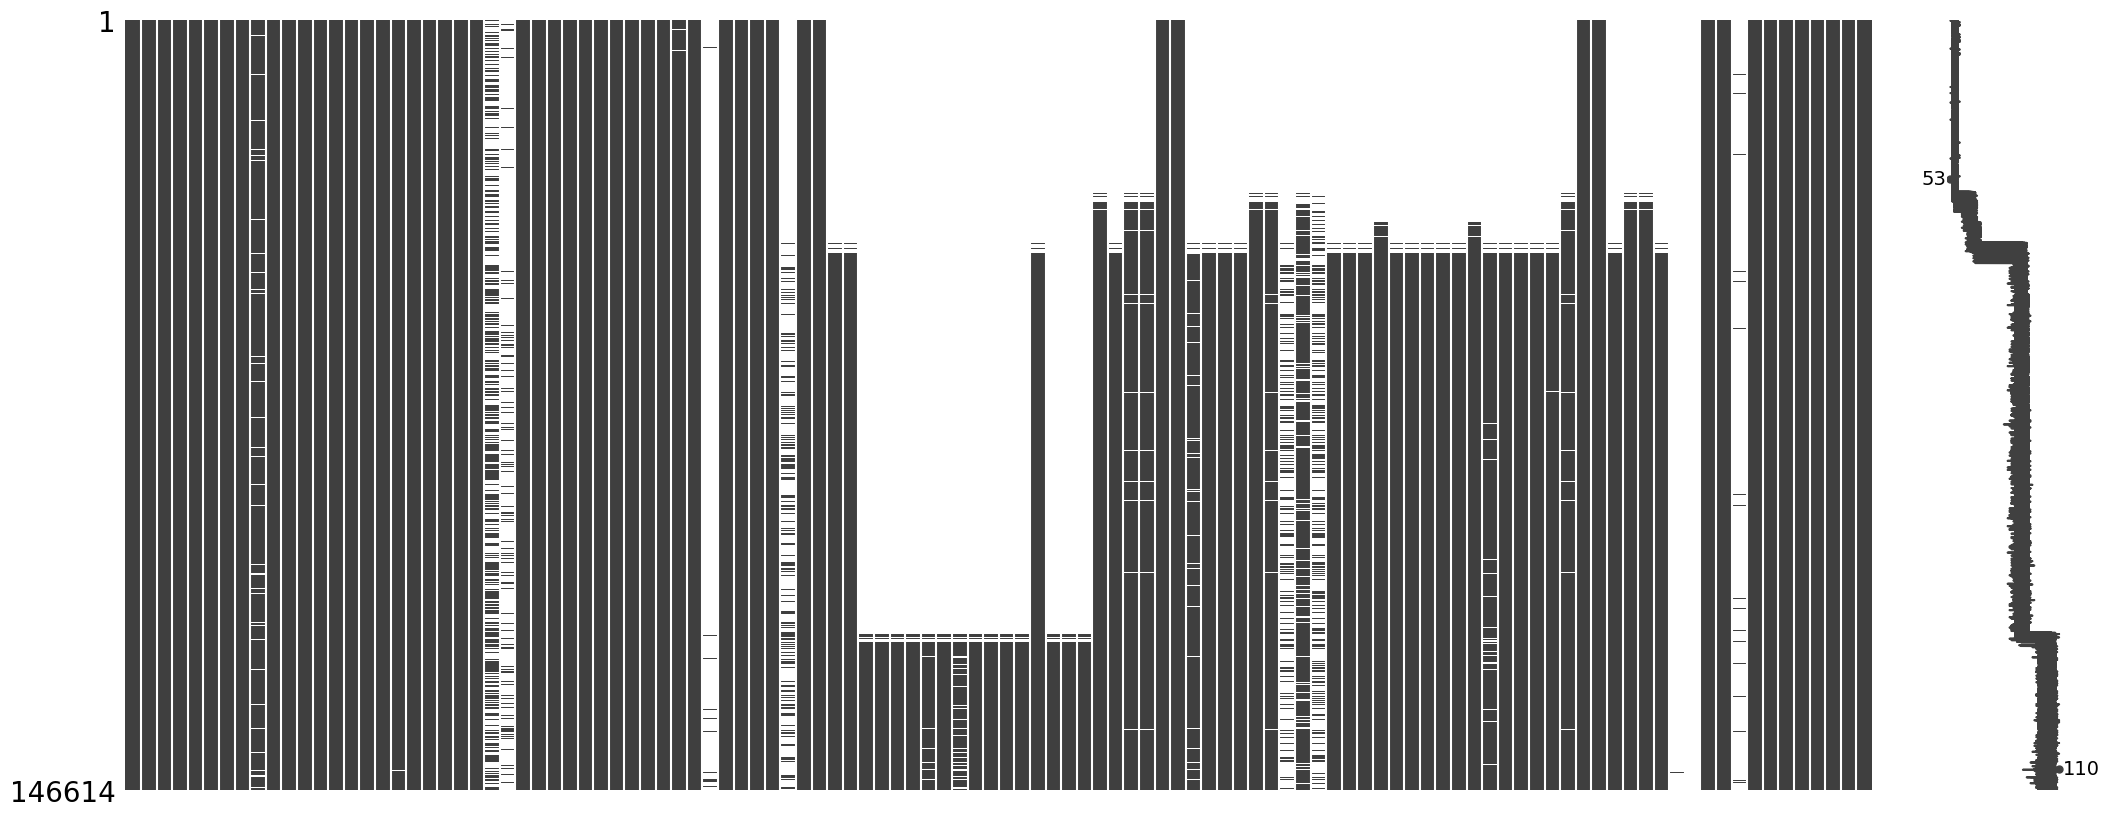

In [97]:
msno.matrix(df_model)
plt.show()

After reviewing the missingno matrix, we performed a final audit to capture residual data leakage that bypassed our initial classification rules. Additionally, we identified a group of variables introduced by Lending Club in late 2015 (such as il_util and open_acc_6m). Since these features are missing in over 80% of our historical records, their inclusion would introduce a historical cohort bias. To ensure model stability and prevent the Logistic Regression from learning patterns based on data availability periods rather than credit risk, we decided to remove them.

In [98]:
# Check exactly what's left with high missingness
missing_report = df_model.isnull().mean().sort_values(ascending=False) * 100
print("--- Features with highest missingness (%) ---")
print(missing_report.head(40))

--- Features with highest missingness (%) ---
orig_projected_additional_accrued_interest    99.826756
payment_plan_start_date                       99.733313
next_pymnt_d                                  99.094220
debt_settlement_flag_date                     98.296888
mths_since_last_record                        87.672391
il_util                                       82.919094
mths_since_recent_bc_dlq                      82.691285
mths_since_last_major_derog                   81.662051
mths_since_rcnt_il                            80.696250
all_util                                      80.196980
open_il_24m                                   80.193570
open_acc_6m                                   80.193570
total_cu_tl                                   80.193570
inq_fi                                        80.193570
max_bal_bc                                    80.193570
open_rv_24m                                   80.193570
open_il_12m                                   80.193570
op

In [99]:
# Define leakage columns and variables with >80% missing values (except mths_since)
leakage_to_drop = [
    'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 
    'next_pymnt_d', 'debt_settlement_flag_date','last_pymnt_d','last_credit_pull_d'
]

# Define leakage columns and variables with more than 80% missing values (except mths_since).
high_null_noise = [
    'il_util', 'all_util', 'open_acc_6m', 'open_act_il', 'open_il_12m', 
    'open_il_24m', 'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 
    'total_bal_il', 'inq_last_12m', 'inq_fi', 'total_cu_tl', 'mths_since_rcnt_il'
]

# Execute drop
cols_to_remove = leakage_to_drop + high_null_noise
df_model.drop(columns=[c for c in cols_to_remove if c in df_model.columns], inplace=True)

print(f"✅ Limpieza final de df_model completada.")
print(f"Columnas restantes: {df_model.shape[1]}")

✅ Limpieza final de df_model completada.
Columnas restantes: 92


In [100]:
# Final reporting post noise cleaning
missing_report_final = df_model.isnull().mean().sort_values(ascending=False) * 100
print("--- Final Missingness Report (df_model) ---")
print(missing_report_final[missing_report_final > 0])

--- Final Missingness Report (df_model) ---
mths_since_last_record            87.672391
mths_since_recent_bc_dlq          82.691285
mths_since_last_major_derog       81.662051
mths_since_recent_revol_delinq    74.571323
mths_since_last_delinq            55.408078
mo_sin_old_il_acct                32.241123
num_tl_120dpd_2m                  32.142906
mths_since_recent_inq             31.301240
pct_tl_nvr_dlq                    30.068070
avg_cur_bal                       30.055793
num_rev_accts                     30.053065
num_actv_rev_tl                   30.052382
tot_cur_bal                       30.052382
tot_coll_amt                      30.052382
total_rev_hi_lim                  30.052382
num_accts_ever_120_pd             30.052382
mo_sin_rcnt_tl                    30.052382
mo_sin_old_rev_tl_op              30.052382
mo_sin_rcnt_rev_tl_op             30.052382
num_bc_tl                         30.052382
num_tl_op_past_12m                30.052382
num_op_rev_tl                   

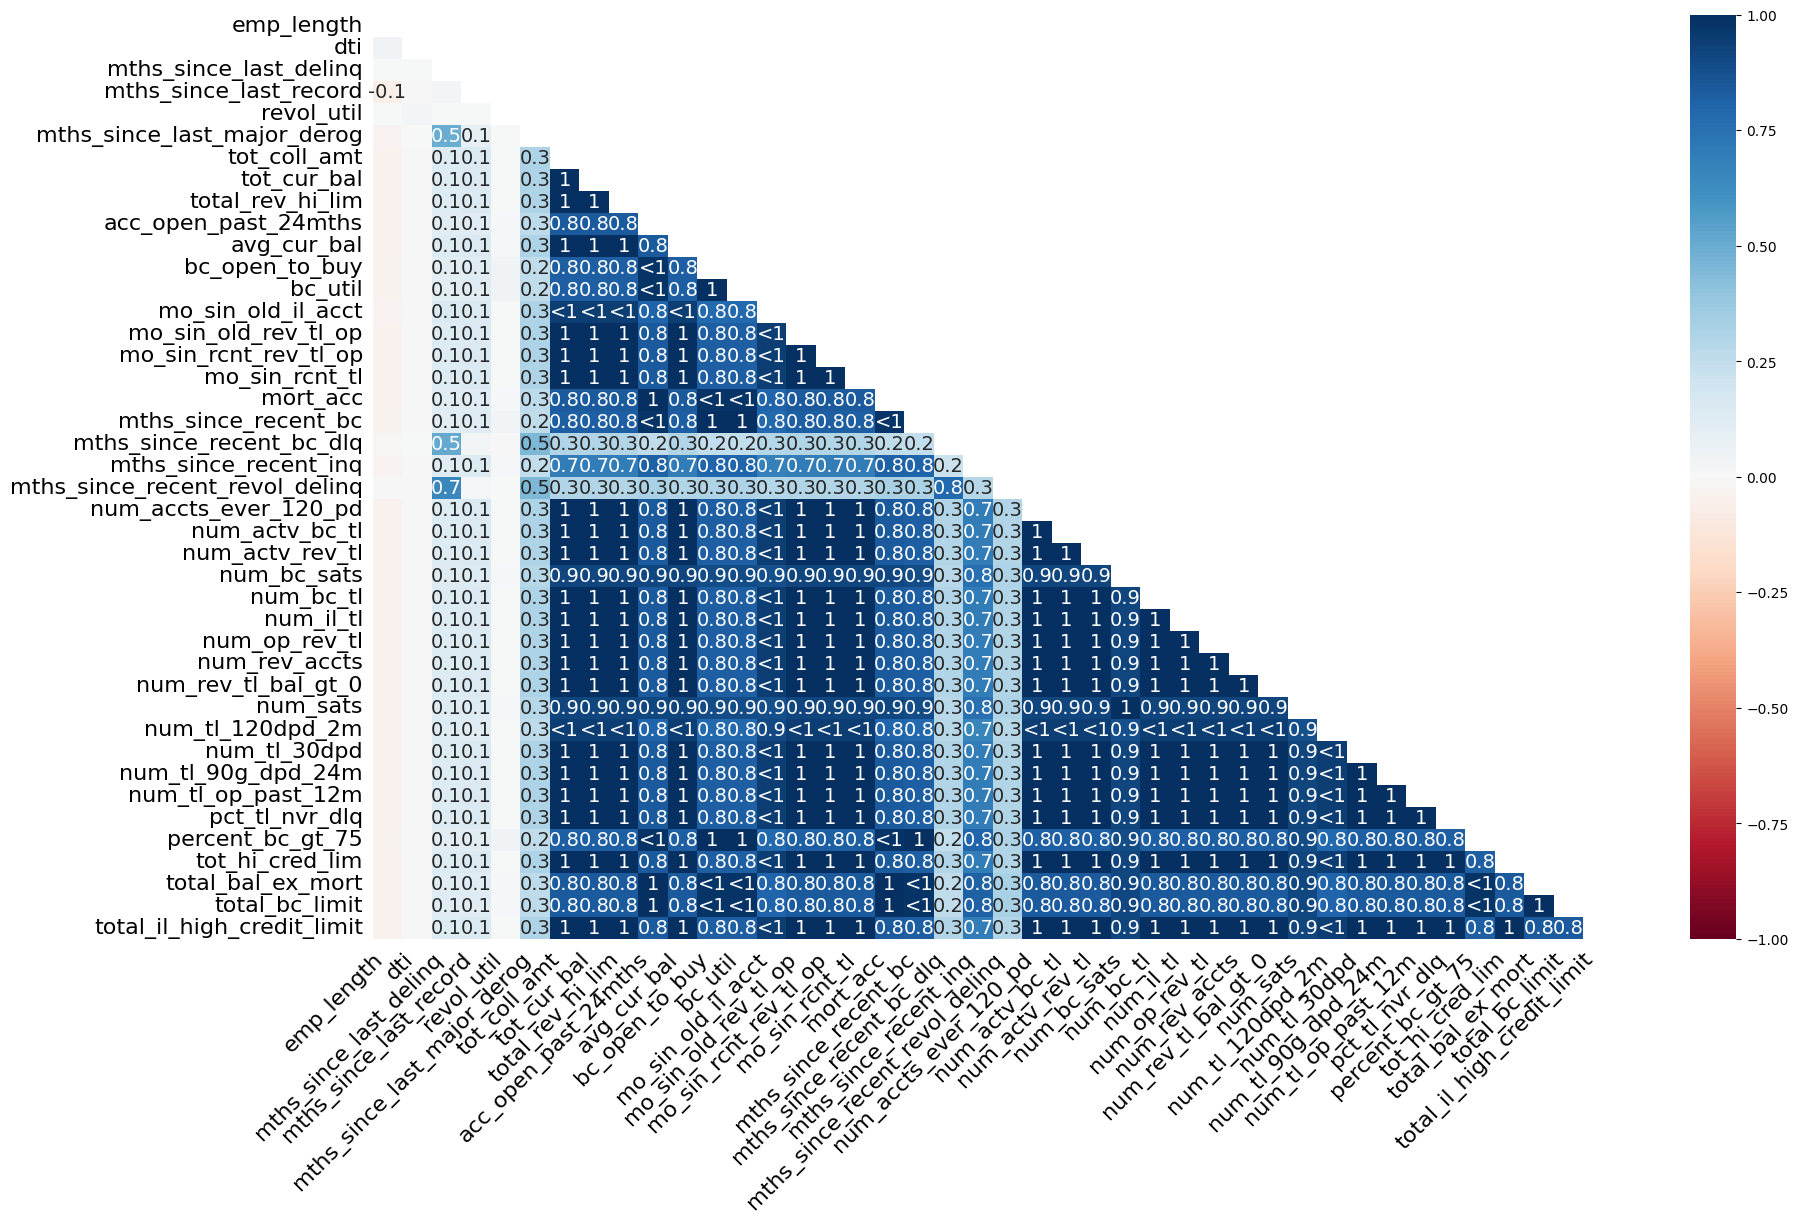

In [101]:
msno.heatmap(df_model)
plt.show()

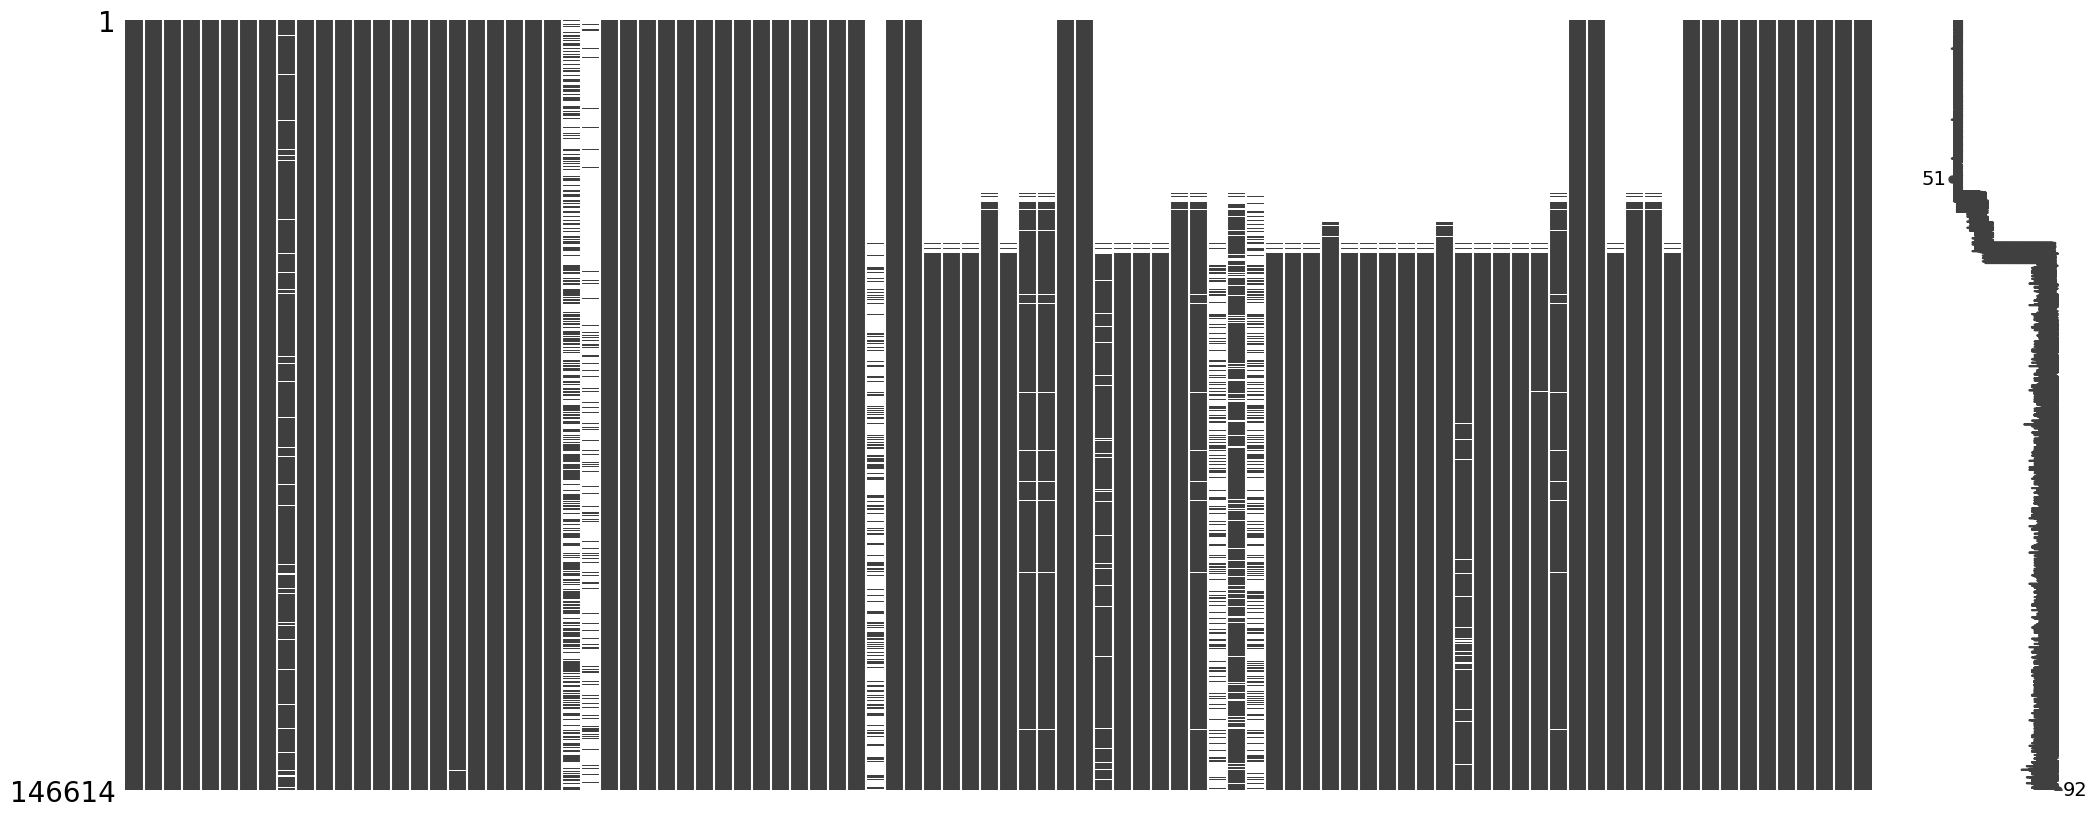

In [102]:
msno.matrix(df_model)
plt.show()

The missingno matrix confirms that data is missing in logical patterns rather than randomly. We identified two main types of missingness:

Structural (Informative): Columns like mths_since_last_delinq (55-88% missing) represent borrowers with no negative credit events. These are informative nulls that we will preserve and impute with a sentinel value (999).

Technical Blocks: A significant block of features (30% missing) fails simultaneously. The Heatmap shows 1.0 correlations between these nulls, proving they are record-level gaps from the credit bureau.

Conclusion: The high correlation between missing values confirms that data fails in blocks. This justifies a consistent strategy: median imputation for technical blocks and sentinel values (999) for structural features, ensuring the model captures both the presence and absence of credit history correctly.

# Train Test Split

Instead of a standard random shuffle, we implemented a Temporal Split based on the loan issuance date (issue_d). We sorted the data chronologically and used the first 80% of the records (2010–2015) for training, while reserving the most recent 20% (2016–2018) as an Out-of-Time (OOT) test set.

Rational: In credit risk modeling, it is vital to ensure the model can generalize to future economic conditions. A temporal split is the most realistic evaluation method because it prevents Look-ahead Bias (training on future information to predict the past). Our results show that the default rate increased from 17% in the training period to 25.4% in the test period. This shift represents a real-world challenge: the model must be robust enough to maintain predictive power even when the macroeconomic environment or borrower profiles evolve over time.

In [103]:
#Sort values by emission date
df_model = df_model.sort_values('issue_d')

#Define temporal cutoff point (80%)
split_date = df_model['issue_d'].quantile(0.8)

#Temporary split
train_df = df_model[df_model['issue_d'] <= split_date]
test_df  = df_model[df_model['issue_d'] > split_date]

#Split features and target
X_train = train_df.drop(columns=['target_default'])
y_train = train_df['target_default']

X_test  = test_df.drop(columns=['target_default'])
y_test  = test_df['target_default']

#6. Extract and store the dates, then remove them from X to avoid training with them
train_dates = X_train.pop('issue_d')
test_dates  = X_test.pop('issue_d')

print(f"Temporal split done.")
print(f"Training: {train_dates.min().date()} a {train_dates.max().date()} ({len(X_train)} filas)")
print(f"Test (Out-of-Time): {test_dates.min().date()} a {test_dates.max().date()} ({len(X_test)} filas)")

print("\nTarget distribution:")
print(f"Train:\n{y_train.value_counts(normalize=True) * 100}")
print(f"Test:\n{y_test.value_counts(normalize=True) * 100}")

Temporal split done.
Training: 2010-06-01 a 2015-12-01 (118374 filas)
Test (Out-of-Time): 2016-01-01 a 2018-12-01 (28240 filas)

Target distribution:
Train:
target_default
0    82.953182
1    17.046818
Name: proportion, dtype: float64
Test:
target_default
0    74.281161
1    25.718839
Name: proportion, dtype: float64


In [104]:
#Separate numerical and categorical features

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

print("Numerical columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

Numerical columns: 75
Categorical columns: 14


#Numerical Strategic Imputation (Structural & General)

Imputation will be performed following a dual strategy based on the nature of the missing data:

Sentinel Value Imputation (999): For structural missingness (e.g., mths_since_last_delinq), we will fill nulls with a value of 999. This explicitly signals to the Logistic Regression that these borrowers have no record of delinquency, treating them as a distinct risk group.

Median/Mode Imputation: For technical gaps or random missingness, we will use the Median for numerical features and the Mode for categorical ones.

Rational: To prevent Data Leakage, all imputation parameters (medians and modes) will be calculated strictly using the Training Set (X_train). These parameters will then be applied to both the training and test sets. This ensures that the test set remains completely "unseen" and that no information from the 2016–2018 period influences the 2010–2015 training phase.

#Missing Value Imputation (post–split)

All imputation strategies are fit on the training set only and then applied to the test set, to avoid data leakage.

In [105]:
# NUMERICAL IMPUTATION

# A. Identifying columns
mths_since_cols = [col for col in X_train.columns if col.startswith('mths_since')]
all_numeric_cols = X_train.select_dtypes(include=['number']).columns
general_numeric_cols = [c for c in all_numeric_cols if c not in mths_since_cols]

# B. Sentinel Imputation (999)
X_train[mths_since_cols] = X_train[mths_since_cols].fillna(999)
X_test[mths_since_cols] = X_test[mths_since_cols].fillna(999)

# C. Median Imputation
# We store the medians to ensure we use the SAME value for Train and Test
for col in general_numeric_cols:
    if X_train[col].isnull().any():
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_test[col] = X_test[col].fillna(median_val)

print("🔍 --- NUMERICAL IMPUTATION REPORT --- 🔍")
print(f"✅ Structural columns (999): {len(mths_since_cols)}")
print(f"✅ General numeric columns (Median): {len(general_numeric_cols)}")
print(f"❌ Numerical nulls left in X_train: {X_train.select_dtypes(include=['number']).isnull().sum().sum()}")

🔍 --- NUMERICAL IMPUTATION REPORT --- 🔍
✅ Structural columns (999): 7
✅ General numeric columns (Median): 68
❌ Numerical nulls left in X_train: 0


In [106]:
# Check for remaining nulls in numerical columns
num_nulls = X_train.select_dtypes(include=['number']).isnull().sum().sum()
print(f"Total numerical nulls: {num_nulls}")

Total numerical nulls: 0


In [107]:
# Check if 999 exists in structural columns
print(X_train[mths_since_cols].describe().loc[['min', 'max']])

     mths_since_last_delinq  mths_since_last_record  \
min                     0.0                     1.0   
max                   999.0                   999.0   

     mths_since_last_major_derog  mths_since_recent_bc  \
min                          0.0                   0.0   
max                        999.0                 999.0   

     mths_since_recent_bc_dlq  mths_since_recent_inq  \
min                       0.0                    0.0   
max                     999.0                  999.0   

     mths_since_recent_revol_delinq  
min                             0.0  
max                           999.0  


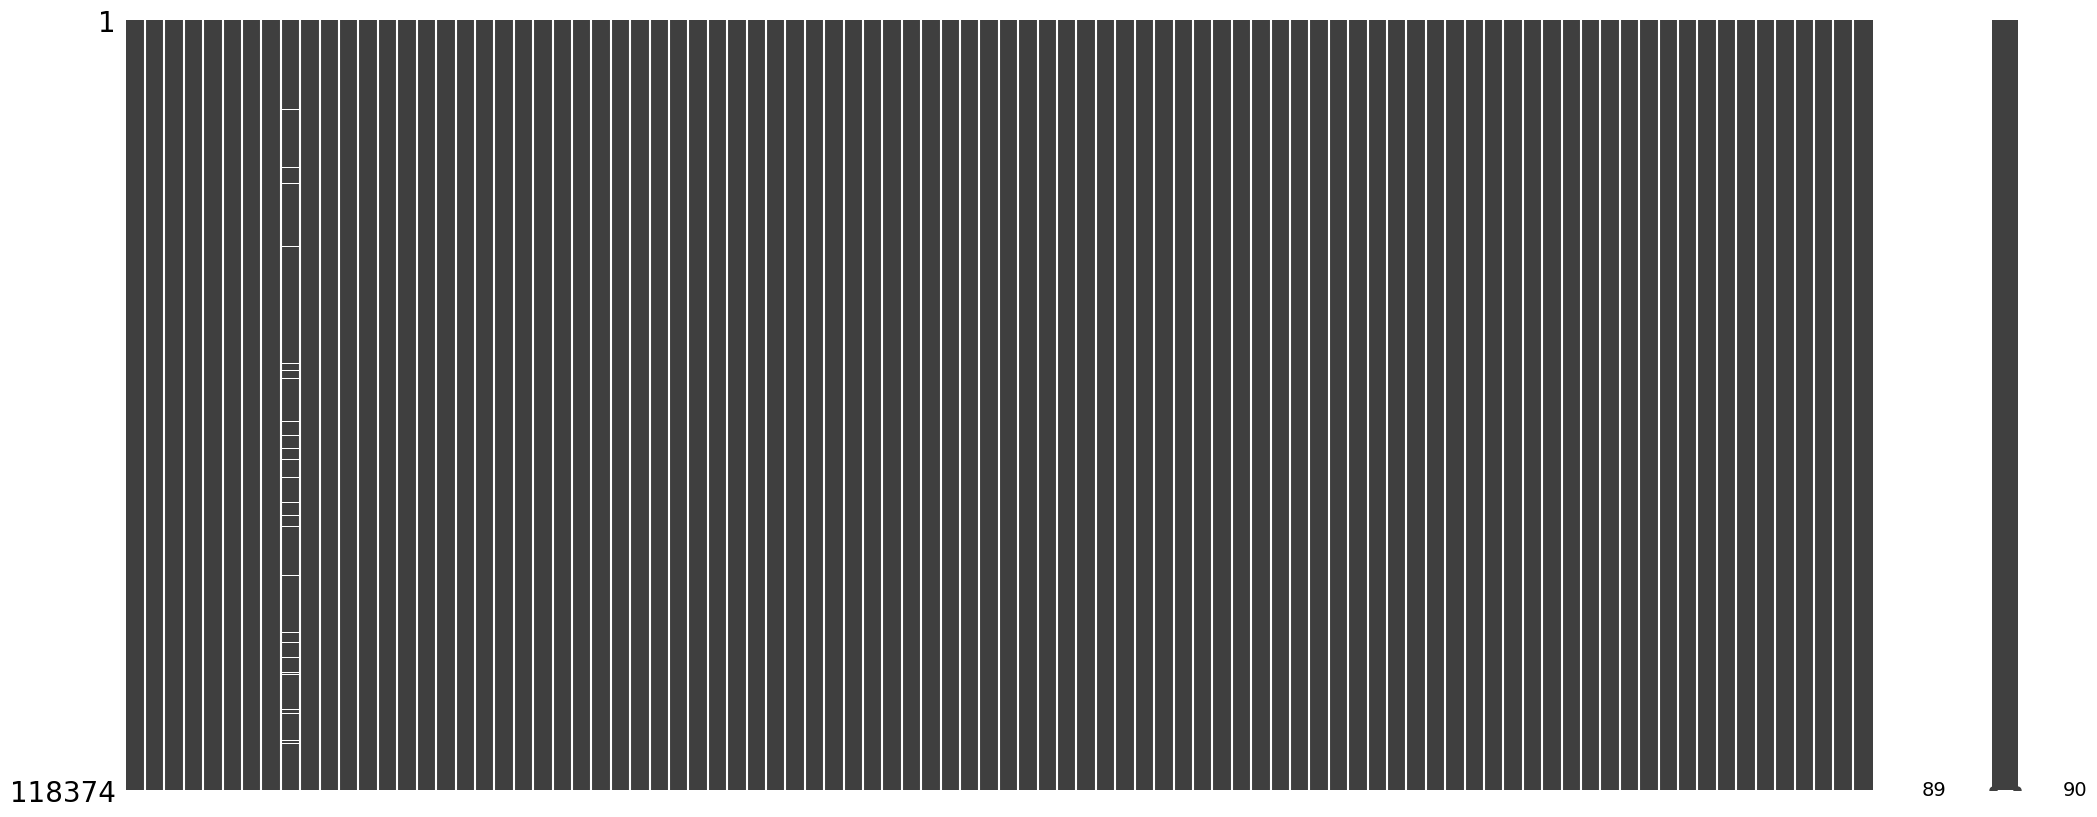

In [108]:
msno.matrix(X_train)
plt.show()

In [109]:
#Check for missing values in all categorical variables
print("Null count in Categorical Columns:")
print(X_train[cat_cols].isnull().sum())

Null count in Categorical Columns:
term                       0
grade                      0
sub_grade                  0
emp_length              5168
home_ownership             0
verification_status        0
pymnt_plan                 0
purpose                    0
zip_code                   0
addr_state                 0
initial_list_status        0
application_type           0
disbursement_method        0
debt_settlement_flag       0
dtype: int64


The missingno matrix appears to show only one categorical feature because it exclusively highlights columns with missing data. While X_train contains 14 categorical features, 13 of them are 100% complete and appear as solid black bars. Only emp_length exhibits the "striped" pattern indicating missing values.

For emp_length, missing values often represent either structural omission or cases where the borrower's employment status doesn't fit standard categories. Imputing with the Mode maintains the existing distribution's strength, while an "Unknown" category avoids making assumptions about the borrower's stability. Given that this variable represents a significant proxy for credit risk stability, we will treat it with care during the encoding phase.

In [110]:
# Manual imputation of categorical 
X_train['emp_length'] = X_train['emp_length'].fillna('Unknown')
X_test['emp_length'] = X_test['emp_length'].fillna('Unknown')

# Final verification
print(f"Remaining nulls in emp_length: {X_train['emp_length'].isnull().sum()}")

Remaining nulls in emp_length: 0


In [111]:
# CATEGORICAL IMPUTATION

# Apply "Unknown" to categorical nulls to avoid bias
for col in cat_cols:
    if X_train[col].isnull().any():
        X_train[col] = X_train[col].fillna('Unknown')
        X_test[col] = X_test[col].fillna('Unknown')

print("✅ Categorical imputation complete using 'Unknown' label.")
print(f"Total nulls in X_train: {X_train.isnull().sum().sum()}")

✅ Categorical imputation complete using 'Unknown' label.
Total nulls in X_train: 0


#Categorical Feature audit and strategy

Before applying any encoding, we must categorize each of the 14 features based on their mathematical relationship with the target variable:

- Binary: Features with only two possible values (e.g., term, pymnt_plan). These can be directly mapped to 0 and 1.

- Ordinal: Features with a natural, inherent rank (e.g., grade A > B > C). These require Label Encoding or Mapping to preserve the risk hierarchy.

- Nominal (Low Cardinality): Categories without order and few unique values (e.g., home_ownership). These are ideal for One-Hot Encoding.

- Nominal (High Cardinality): Categories with many unique values (e.g., addr_state, purpose). These require grouping or special handling to avoid creating hundreds of sparse columns.

Using a "one-size-fits-all" approach would create an excessively sparse matrix, potentially leading to overfitting or the "curse of dimensionality." A tailored strategy ensures the model captures the underlying risk signals efficiently.

In [112]:
# Analyzing the nature of the 14 categorical variables
cat_summary = []

for col in cat_cols:
    cat_summary.append({
        'Feature': col,
        'Unique_Values': X_train[col].nunique(),
        'Sample_Values': X_train[col].unique()[:5].tolist(),
    })

import pandas as pd
df_cat_audit = pd.DataFrame(cat_summary)
print("🔍 --- CATEGORICAL AUDIT --- 🔍")
print(df_cat_audit)

🔍 --- CATEGORICAL AUDIT --- 🔍
                 Feature  Unique_Values  \
0                   term              2   
1                  grade              7   
2              sub_grade             35   
3             emp_length             12   
4         home_ownership              5   
5    verification_status              3   
6             pymnt_plan              2   
7                purpose             14   
8               zip_code            877   
9             addr_state             49   
10   initial_list_status              2   
11      application_type              2   
12   disbursement_method              1   
13  debt_settlement_flag              2   

                                        Sample_Values  
0                            [ 36 months,  60 months]  
1                                     [A, C, B, D, E]  
2                                [A3, C2, B3, D3, D4]  
3        [6 years, 3 years, 5 years, 2 years, 1 year]  
4                  [RENT, OWN, MORTGAGE, OTH

Based on the Categorical Audit, we have identified four distinct groups of features that require tailored encoding techniques to optimize the Logistic Regression model:

- Binary Features (0 or 1): Features like term, pymnt_plan, initial_list_status, application_type, and debt_settlement_flag. These have exactly 2 unique values and will be mapped to a binary integer format.

- Ordinal Features (Ordered Rank): grade, sub_grade, and emp_length. These carry a natural hierarchy of risk (e.g., Grade A is safer than Grade G). We will use Ordinal Mapping to preserve this mathematical relationship.

- Nominal Low-Cardinality (One-Hot): home_ownership, verification_status, and purpose (14 values). These have no inherent order and few categories, making them ideal for One-Hot Encoding.

- High-Cardinality/Redundant: zip_code (867 values) and addr_state (51 values) create too much noise for a Logistic Regression. disbursement_method only has 1 value ("Cash"), meaning it provides zero predictive power and should be dropped.

Preserving the order in grade and sub_grade is critical because a linear model like Logistic Regression can learn that risk increases as the grade moves from 1 to 7. Conversely, One-Hot Encoding these would treat the difference between A and B the same as the difference between A and G, losing valuable information.

In [113]:
# Drop constant features
X_train.drop(columns=['disbursement_method'], inplace=True, errors='ignore')
X_test.drop(columns=['disbursement_method'], inplace=True, errors='ignore')

In [114]:
# 1. Mapping Grades (A=1, B=2... G=7)
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
X_train['grade'] = X_train['grade'].map(grade_map)
X_test['grade'] = X_test['grade'].map(grade_map)

# 2. Mapping emp_length (Converting strings to numbers)
emp_map = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
    '10+ years': 10, 'Unknown': -1 # We use -1 as our "missing" signal here
}
X_train['emp_length'] = X_train['emp_length'].map(emp_map)
X_test['emp_length'] = X_test['emp_length'].map(emp_map)

In [115]:
# Encoding 'term' (36 months = 0, 60 months = 1)
X_train['term'] = X_train['term'].apply(lambda x: 1 if '60' in x else 0)
X_test['term'] = X_test['term'].apply(lambda x: 1 if '60' in x else 0)

In [116]:
# CLEANING HIGH-CARDINALITY & REDUNDANT FEATURES

# 1. List of features to drop
cols_to_drop_final = ['zip_code', 'addr_state', 'disbursement_method']

# 2. Execute drop
X_train.drop(columns=[c for c in cols_to_drop_final if c in X_train.columns], inplace=True)
X_test.drop(columns=[c for c in cols_to_drop_final if c in X_test.columns], inplace=True)

# 3. Update our categorical list
cat_cols = [c for c in cat_cols if c not in cols_to_drop_final]

print(f"✅ High-cardinality and redundant features removed.")
print(f"Remaining categorical columns for One-Hot Encoding: {len(cat_cols)}")

✅ High-cardinality and redundant features removed.
Remaining categorical columns for One-Hot Encoding: 11


In [117]:
# Update the list of categorical columns based on the current state of X_train
cat_cols_remaining = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"🔍 --- REMAINING CATEGORICAL COLUMNS ({len(cat_cols_remaining)}) --- 🔍")
for i, col in enumerate(cat_cols_remaining):
    unique_count = X_train[col].nunique()
    print(f"{i+1}. {col:25} | Unique Values: {unique_count}")

# Quick check of the ones we already mapped
print("\n✅ Verification of previously mapped columns:")
print(f"Grade type:      {X_train['grade'].dtype}")
print(f"Emp_length type: {X_train['emp_length'].dtype}")

🔍 --- REMAINING CATEGORICAL COLUMNS (8) --- 🔍
1. sub_grade                 | Unique Values: 35
2. home_ownership            | Unique Values: 5
3. verification_status       | Unique Values: 3
4. pymnt_plan                | Unique Values: 2
5. purpose                   | Unique Values: 14
6. initial_list_status       | Unique Values: 2
7. application_type          | Unique Values: 2
8. debt_settlement_flag      | Unique Values: 2

✅ Verification of previously mapped columns:
Grade type:      int64
Emp_length type: int64


The final stage of feature engineering focuses on the remaining 8 variables. We apply a differentiated approach to maximize the model's predictive power:

-Sub-grade (Ordinal Mapping): Given that sub_grade contains 35 levels with a clear risk hierarchy (e.g., A1 is safer than G5), we map it to a range of 1 to 35. This allows the Logistic Regression to treat the grade as a continuous risk indicator rather than independent, unrelated categories.

-Nominal Features (One-Hot Encoding): For the remaining 7 features such as home_ownership and purpose, we use One-Hot Encoding. This creates binary (0 or 1) columns for each category, which is the standard requirement for linear models to process non-ordered data.

Completing this step ensures the dataset is 100% numerical. By using pd.get_dummies with drop_first=True, we avoid the "dummy variable trap" (multicollinearity), which is essential for the stability of Logistic Regression coefficients.

In [118]:
# 1. Ordinal mapping of Sub-Grade (A1=1, A2=2... G5=35)
# We generate the mapping based on the natural alphabetical/numerical order
sub_grade_list = sorted(X_train['sub_grade'].unique())
sub_grade_map = {val: i+1 for i, val in enumerate(sub_grade_list)}

X_train['sub_grade'] = X_train['sub_grade'].map(sub_grade_map)
X_test['sub_grade'] = X_test['sub_grade'].map(sub_grade_map)

# 2. One-Hot Encoding for the remaining nominal variables
# 'drop_first=True' is essential for Logistic Regression (avoids redundancy)
nom_cols = ['home_ownership', 'verification_status', 'purpose', 
            'pymnt_plan', 'initial_list_status', 'application_type', 
            'debt_settlement_flag']

X_train = pd.get_dummies(X_train, columns=nom_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nom_cols, drop_first=True)

# 3.Column alignment (ensures that Train and Test have exactly the same columns)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print("🚀 --- FINAL PREPARATION COMPLETE --- 🚀")
print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of X_test:  {X_test.shape}")
print(f"Any non-numeric columns left? {X_train.select_dtypes(exclude=['number']).columns.tolist()}")

🚀 --- FINAL PREPARATION COMPLETE --- 🚀
Final shape of X_train: (118374, 103)
Final shape of X_test:  (28240, 103)
Any non-numeric columns left? ['earliest_cr_line', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'pymnt_plan_y', 'initial_list_status_w', 'application_type_Joint App', 'debt_settlement_flag_Y']


The output shows that One-Hot Encoding successfully created indicator variables for categories like home_ownership and purpose. While these columns are now binary (0/1), the system might still flag them as non-numeric because of their specific bit-type. More importantly, the feature earliest_cr_line remains as a datetime object, which is incompatible with Logistic Regression.

To finalize the preprocessing, we must:

- Transform dates into duration: Convert earliest_cr_line into a numerical value, such as "years of credit history".

- Cast Booleans to Integers: Ensure all 0/1 columns are explicitly recognized as integers to avoid errors during the model fitting stage.

In [119]:
# 1.Transform 'earliest_cr_line' into tenure (years)
# We calculate the difference between the loan date and the first credit line
X_train['credit_age_years'] = (train_dates - X_train['earliest_cr_line']).dt.days / 365
X_test['credit_age_years'] = (test_dates - X_test['earliest_cr_line']).dt.days / 365

# 2.Remove the original date column (no longer needed)
X_train.drop(columns=['earliest_cr_line'], inplace=True)
X_test.drop(columns=['earliest_cr_line'], inplace=True)

# 3.Force ALL columns to be numeric (converting True/False to 1/0)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

print("FINAL NUMERIC ALIGNMENT")
print(f"Remaining non-numeric columns: {X_train.select_dtypes(exclude=['number']).columns.tolist()}")
print(f"Final feature count: {X_train.shape[1]}")

FINAL NUMERIC ALIGNMENT
Remaining non-numeric columns: []
Final feature count: 103


Hacer revision de validacion de la data. Para ver como se esta viendo. 

#Anomaly Detection (Outliers)

To ensure the robustness of the Logistic Regression model, we implemented an Isolation Forest algorithm for multivariate outlier detection. Unlike standard univariate methods (like Z-score), Isolation Forest isolates anomalies by randomly selecting a feature and a split value, identifying data points that are easier to "isolate" in a shorter number of steps.

The algorithm identified 5,084 observations (approximately 4.3% of the training set) as outliers (outlier_flag = -1).

A total of 113,422 observations were classified as normal instances (outlier_flag = 1).

In [120]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,118374.0,1.368939e+04,8275.828824,1000.000,7.200000e+03,1.200000e+04,1.907500e+04,3.500000e+04
funded_amnt,118374.0,1.361072e+04,8222.040937,1000.000,7.200000e+03,1.200000e+04,1.882500e+04,3.500000e+04
funded_amnt_inv,118374.0,1.355672e+04,8197.393724,400.000,7.200000e+03,1.200000e+04,1.860000e+04,3.500000e+04
term,118374.0,2.667309e-01,0.442252,0.000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
int_rate,118374.0,1.316985e+01,4.356804,5.320,9.990000e+00,1.299000e+01,1.599000e+01,2.899000e+01
installment,118374.0,4.103130e+02,243.841860,20.220,2.299900e+02,3.589750e+02,5.405600e+02,1.409990e+03
grade,118374.0,2.698946e+00,1.337418,1.000,2.000000e+00,2.000000e+00,4.000000e+00,7.000000e+00
sub_grade,118374.0,1.147527e+01,6.611894,1.000,7.000000e+00,1.000000e+01,1.600000e+01,3.500000e+01
emp_length,118374.0,5.502087e+00,3.797773,-1.000,2.000000e+00,5.000000e+00,1.000000e+01,1.000000e+01
annual_inc,118374.0,7.238456e+04,50313.481085,1200.000,4.500000e+04,6.150000e+04,8.700000e+04,3.900000e+06


In [121]:
iso = IsolationForest(random_state=123)
df_num = X_train.copy()
df_num['outlier_flag'] = iso.fit_predict(X_train)

In [122]:
df_num['outlier_flag'].value_counts()

outlier_flag
 1    111775
-1      6599
Name: count, dtype: int64

ACA QUEDE!!! SE TRATARAN LOS OUTLIERS CON ROBUST SCALER PORQUE SI LOS ELIMINAMOS PODRIAMOS ESTAR ELIMINANDO INFORMACIÓN DE PERFILES RIESGOSOS Y SESGAR EL MODELO A PERFILES SANOS. 

SIGUIENTE PASO LUEGO DEL ROBUST SCALER: SELECCION DE CARACTERISTICAS

Al explorar la columna objetivo loan_status, se identificó que algunas clases tenían un número extremadamente bajo de registros (por ejemplo, solo uno o dos casos). Esto genera problemas al dividir el dataset en entrenamiento y prueba usando estratificación (stratify=y), ya que no es posible mantener la proporción de clases cuando algunas aparecen muy pocas veces.

Para evitar este error y asegurar que el modelo pueda generalizar correctamente, se filtraron estas clases minoritarias, manteniendo únicamente las clases con un número suficiente de observaciones. Esto permite realizar un train-test split estratificado seguro y garantiza que tanto el conjunto de entrenamiento como el de prueba tengan representatividad adecuada de cada clase relevante.

In [123]:
# # Contar la frecuencia de cada clasegit 
# print(df['loan_status'].value_counts())

# # Mantener solo clases frecuentes 
# frequent_classes = df['loan_status'].value_counts()[df['loan_status'].value_counts() > 5].index
# df = df[df['loan_status'].isin(frequent_classes)]

In [124]:

# X = df.drop(columns=['loan_status'])  # Variables predictoras
# y = df['loan_status']                 # Target

# # Split 80% train / 20% test
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

## Codificacion columnas tipo object

In [125]:
# df.dtypes.value_counts()

In [126]:
# df.select_dtypes(include='object').columns

Manejo de fechas

Las columnas de tipo fecha (issue_d, earliest_cr_line, last_pymnt_d, etc.) no se pueden usar directamente en un modelo. Por eso:

- Convertimos las columnas a tipo datetime.

- Creamos features derivadas, como antigüedad del crédito (credit_age) en años, que pueden ser más útiles para el modelo que la fecha cruda.

In [127]:
# date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 
#              'next_pymnt_d', 'last_credit_pull_d', 
#              'payment_plan_start_date', 'debt_settlement_flag_date']

# for col in date_cols:
#     X_train[col] = pd.to_datetime(X_train[col], errors='coerce')
#     X_test[col] = pd.to_datetime(X_test[col], errors='coerce')

# # antigüedad del crédito
# X_train['credit_age'] = (pd.to_datetime('today') - X_train['earliest_cr_line']).dt.days / 365
# X_test['credit_age'] = (pd.to_datetime('today') - X_test['earliest_cr_line']).dt.days / 365

Codificación de variables categóricas (One-hot eficiente)

- a) Variables nominales (sin orden) – One-hot eficiente

Usamos drop='first' para evitar multicolinealidad (importante en regresión logística).

In [128]:
# categorical_cols = ['grade', 'sub_grade', 'home_ownership', 
#                     'verification_status', 'purpose', 
#                     'initial_list_status', 'application_type', 
#                     'disbursement_method']

# # One-hot encoder eliminando la primera categoría
# ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# # Ajustamos solo con train
# ohe.fit(X_train[categorical_cols])

# # Transformamos train y test
# X_train_encoded = pd.DataFrame(ohe.transform(X_train[categorical_cols]), 
#                                columns=ohe.get_feature_names_out(categorical_cols), 
#                                index=X_train.index)

# X_test_encoded = pd.DataFrame(ohe.transform(X_test[categorical_cols]), 
#                               columns=ohe.get_feature_names_out(categorical_cols), 
#                               index=X_test.index)

# # Reemplazamos las columnas originales por las codificadas
# X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded)
# X_test = X_test.drop(columns=categorical_cols).join(X_test_encoded)

- b) Variables ordinales (con orden)

El orden es relevante, por eso asignamos números manualmente:

In [129]:
# emp_length_map = {
#     '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,
#     '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
#     '8 years': 8, '9 years': 9, '10+ years': 10
# }

# X_train['emp_length'] = X_train['emp_length'].map(emp_length_map)
# X_test['emp_length'] = X_test['emp_length'].map(emp_length_map)

Eliminación de texto libre (desc)

El texto libre no aporta información estructurada inmediata y procesarlo requeriría NLP. Para mantener un modelo interpretable y eficiente, se eliminó.

In [130]:
# X_train = X_train.drop(columns=['desc'])
# X_test = X_test.drop(columns=['desc'])

Manejo de columnas binarias

Convertimos y/n a 1/0:

In [131]:
# binary_cols = ['pymnt_plan', 'debt_settlement_flag']
# for col in binary_cols:
#     X_train[col] = X_train[col].map({'y': 1, 'n': 0})
#     X_test[col] = X_test[col].map({'y': 1, 'n': 0})

In [132]:
# Revisar los tipos de todas las columnas
# print(X_train.dtypes.value_counts())

In [133]:
# Columnas que siguen siendo object
# object_cols = X_train.select_dtypes(include='object').columns
# print(object_cols)

Manejo de columnas tipo object restantes

Al revisar el dataset tras la limpieza y codificación inicial, quedaron algunas columnas tipo object: term, emp_title, url, title, zip_code y addr_state.

Estas columnas no se eliminaron en los pasos anteriores porque algunas requerían transformaciones específicas para ser útiles en el modelo, mientras que otras podían eliminarse para mantener interpretabilidad y eficiencia:

- term: contiene la duración del préstamo como texto (ej. "36 months"). Se convirtió a un valor numérico en meses para que el modelo pueda utilizarlo directamente.

- emp_title, url, title: columnas de texto libre con demasiadas categorías únicas y sin estructura clara. Se eliminaron para simplificar el modelo y mantener su interpretabilidad.

- zip_code: originalmente un código postal completo, se redujo a los primeros 3 dígitos y se codificó numéricamente mediante OrdinalEncoder, manejando correctamente los códigos nuevos que aparezcan en el conjunto de prueba. Esto permite conservar información geográfica sin explotar la dimensionalidad.

- addr_state: contiene el estado de residencia. Como tiene pocas categorías, se codificó mediante One-hot con drop='first', generando columnas independientes que el modelo puede interpretar sin introducir redundancia.

Esta revisión garantiza que todas las variables sean numéricas o codificadas correctamente, evitando errores al entrenar una regresión logística y manteniendo la interpretabilidad y eficiencia del modelo.

In [134]:
# # 1️⃣ Convertir 'term' a número de meses (funciona si ya es int o si es string)
# # -----------------------------
# X_train['term'] = X_train['term'].astype(str).str.replace(' months','').astype(int)
# X_test['term'] = X_test['term'].astype(str).str.replace(' months','').astype(int)

# # -----------------------------
# # 2️⃣ Eliminar columnas de texto libre irrelevantes
# # -----------------------------
# cols_to_drop = ['emp_title', 'url', 'title', 'desc']
# X_train = X_train.drop(columns=[c for c in cols_to_drop if c in X_train.columns])
# X_test = X_test.drop(columns=[c for c in cols_to_drop if c in X_test.columns])

# # -----------------------------
# # 3️⃣ Manejo de zip_code (solo 3 primeros dígitos)
# # -----------------------------
# X_train['zip_code'] = X_train['zip_code'].astype(str).str[:3]
# X_test['zip_code'] = X_test['zip_code'].astype(str).str[:3]

# ord_enc_zip = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# X_train[['zip_code']] = ord_enc_zip.fit_transform(X_train[['zip_code']])
# X_test[['zip_code']] = ord_enc_zip.transform(X_test[['zip_code']])

# # -----------------------------
# # 4️⃣ One-hot encoding de addr_state (pocas categorías)
# # -----------------------------
# if 'addr_state' in X_train.columns:
#     ohe_state = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
#     ohe_state.fit(X_train[['addr_state']])

#     X_train_state = pd.DataFrame(ohe_state.transform(X_train[['addr_state']]),
#                                  columns=ohe_state.get_feature_names_out(['addr_state']),
#                                  index=X_train.index)

#     X_test_state = pd.DataFrame(ohe_state.transform(X_test[['addr_state']]),
#                                 columns=ohe_state.get_feature_names_out(['addr_state']),
#                                 index=X_test.index)

#     X_train = X_train.drop(columns=['addr_state']).join(X_train_state)
#     X_test = X_test.drop(columns=['addr_state']).join(X_test_state)

# # -----------------------------
# # 5️⃣ Convertir columnas datetime a métricas numéricas
# # -----------------------------
# date_cols = ['earliest_cr_line', 'issue_d', 'last_pymnt_d',
#              'next_pymnt_d', 'last_credit_pull_d',
#              'payment_plan_start_date', 'debt_settlement_flag_date']

# for col in date_cols:
#     if col in X_train.columns:
#         # Convertir a datetime
#         X_train[col] = pd.to_datetime(X_train[col], errors='coerce')
#         X_test[col] = pd.to_datetime(X_test[col], errors='coerce')
        
#         # Métrica numérica: días desde hoy
#         X_train[col + '_days_since'] = (pd.to_datetime('today') - X_train[col]).dt.days
#         X_test[col + '_days_since'] = (pd.to_datetime('today') - X_test[col]).dt.days

# # Eliminar columnas datetime originales
# X_train = X_train.drop(columns=[c for c in date_cols if c in X_train.columns])
# X_test = X_test.drop(columns=[c for c in date_cols if c in X_test.columns])

# # -----------------------------
# # 6️⃣ Verificación final: no object ni datetime
# # -----------------------------
# print("Tipos de columnas finales X_train:\n", X_train.dtypes.value_counts())
# print("Columnas tipo object restantes:", X_train.select_dtypes(include='object').columns.tolist())

Tras la codificación de las columnas tipo object y la eliminación de las columnas de texto libre irrelevantes, el dataset pasó de tener 94 columnas numéricas y 26 columnas tipo object, a:

215 columnas de tipo float64

4 columnas de tipo int64

Esto refleja que todas las variables categóricas han sido correctamente codificadas:

- Las variables binarias y ordinales se mantienen como numéricas (int64 o float64).

- Las variables categóricas con pocas categorías, como addr_state, se codificaron con One-hot.

- Las columnas de fecha se transformaron a métricas numéricas (días transcurridos desde cada fecha), permitiendo que los modelos interpreten la información temporal.

- Las variables de texto libre que no aportaban información estructurada se eliminaron (emp_title, url, title, desc).

Como resultado, no quedan columnas tipo object ni datetime, asegurando que el dataset esté completamente listo para entrenar modelos de regresión logística, IsolationForest o RandomForest, evitando errores y manteniendo interpretabilidad.

### Codificación del Target (loan_status) a Binario

El objetivo del proyecto es predecir si un préstamo caerá en default o no. Originalmente, la columna loan_status contenía múltiples estados textuales como:

'Charged Off', 'Fully Paid', 'Current', 'Late (16-30 days)', 'Late (31-120 days)', 
'Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid', 'In Grace Period'


Para simplificar el problema a clasificación binaria, se realizó la siguiente transformación:

Se definieron ciertos estados como default (1):
'Charged Off', 'Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid', 'Late (16-30 days)', 'Late (31-120 days)'.

Todos los demás estados se consideraron No Default (0): 'Fully Paid', 'Current', 'In Grace Period'.

Esta codificación asegura que el target sea numérico y binario, compatible con modelos de clasificación como RandomForest, XGBoost o regresión logística, evitando errores por valores categóricos y manteniendo la interpretabilidad del modelo.

In [135]:
# #  Codificar target a binario usando map
# # -----------------------------
# default_labels = {
#     'Charged Off': 1,
#     'Does not meet the credit policy. Status:Charged Off': 1,
#     'Does not meet the credit policy. Status:Fully Paid': 1,
#     'Late (16-30 days)': 1,
#     'Late (31-120 days)': 1,
#     'Fully Paid': 0,
#     'Current': 0,
#     'In Grace Period': 0  # puedes ajustar según tu criterio
# }

# y_train = y_train.map(default_labels)
# y_test = y_test.map(default_labels)

# # Revisar conteo de clases
# print(y_train.value_counts())
# print(y_test.value_counts())

# Outliers

In [136]:
# iso = IsolationForest(random_state=123)
# df_num = X_train.copy()
# df_num['outlier_flag'] = iso.fit_predict(X_train)
# df_num['outlier_flag'].value_counts()

In [137]:
# # Crear copia del dataset de entrenamiento

# df_train_clean = X_train.copy()

# #  Aplicar IsolationForest para detectar outliers
# iso = IsolationForest(random_state=123, contamination='auto')
# df_train_clean['outlier_flag'] = iso.fit_predict(df_train_clean)


# # Eliminar registros considerados outliers (-1)

# df_train_clean = df_train_clean[df_train_clean['outlier_flag'] == 1]


# # Eliminar la columna outlier_flag si no se va a usar como característica
# df_train_clean = df_train_clean.drop(columns=['outlier_flag'])
# y_train_clean = y_train.loc[df_train_clean.index]

# print("Número de registros después de eliminar outliers:", df_train_clean.shape[0])

Se aplicó IsolationForest para identificar registros atípicos en el dataset de entrenamiento. Los outliers son puntos que presentan patrones muy diferentes al resto de los datos y podrían distorsionar los resultados de modelos sensibles, como la regresión logística.

Tras la detección, se eliminaron los 45 registros considerados outliers de un total de 153,846, lo que representa menos del 0.03% del dataset. Esta eliminación asegura que el modelo se entrene sobre datos consistentes, manteniendo la interpretabilidad y evitando que valores extremos afecten los coeficientes.

El dataset resultante conserva prácticamente toda la información original, pero más "limpio", garantizando una base sólida para el entrenamiento de modelos de regresión y otros algoritmos supervisados.

# Seleccion de caracteristicas

## Método 1 Feature importance de RF

In [138]:
# Entrenamiento de RF
model = RandomForestClassifier(random_state=42,n_jobs=-1).fit(df_train_clean, y_train_clean)
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100
# Convertir a DataFrame
df_rf_imp = pd.DataFrame({'feature': df_train_clean.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)
# Calculamos la importancia acumulada
df_rf_imp['rf_importance_acum'] = df_rf_imp['rf_importance'].cumsum()
df_rf_imp

,feature,rf_importance,rf_importance_acum
29,recoveries,22.796984,22.796984
30,collection_recovery_fee,14.670017,37.467001
33,last_fico_range_low,9.094174,46.561175
32,last_fico_range_high,7.830228,54.391403
26,total_rec_prncp,5.386189,59.777592
31,last_pymnt_amnt,4.191683,63.969275
214,last_pymnt_d_days_since,3.450169,67.419444
24,total_pymnt,2.403647,69.823090
25,total_pymnt_inv,2.138192,71.961282
1,funded_amnt,1.950563,73.911845


## Metodo 2 Permutation/Shuffle importance

In [139]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(df_train_clean, y_train_clean, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBClassifier(objective='binary:logistic',random_state=42,use_label_encoder=False,eval_metric='logloss').fit(X_train1, y_train1)

# Realizamos 10 permutaciones por cada característica (se usa neg_mean_absolute_error)
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='accuracy')

df_perm_imp = pd.DataFrame({'feature': df_train_clean.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:40:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,feature,perm_imp
214,last_pymnt_d_days_since,15.866519
26,total_rec_prncp,13.609115
29,recoveries,9.656708
215,next_pymnt_d_days_since,1.372192
2,funded_amnt_inv,1.249309
1,funded_amnt,0.740223
31,last_pymnt_amnt,0.488606
32,last_fico_range_high,0.413836
218,debt_settlement_flag_date_days_since,0.257144
5,installment,0.153766
